# Hyperparam tuning of MLP

Check out some more hperparams for the model to improve from the val loss of 2.17

## Realtime Notes

- Best fixed lr: ~ **0.1122**
- With 200,000 epochs, there is some potential overfitting with a fixed lr
- lr slashing quickly is slightly better than slowly decaying lr, we get similar results in more epochs.
- Batch size best = 128.
- Increase in emb dim overfits the model with the default parameters.
- Hidden dim increase is slight overfit but better than the emb dim increase
- Direct connections help slightly!
- If we increase window size, emb dim increase will help !

# Best model:
- **Window size** : 5
- **Embedding dim** : 20
- **Hidden dim** : 400
- **Batch size** : 128
- **Steps** : 300000
- **Learning Rate**: Variable with slashing by 10 after 100000 steps
- **Direct connections**: Present

# Loss values
- **Train**: 2.047
- **Val**: 2.104
- **Test**: 2.128

In [2]:
with open("../names.txt", 'r') as file:
    names = file.read().splitlines()

len(names)

32033

## Create the intermediate dictionaries

In [4]:
chars = sorted(list(set("".join(name for name in names))))
chars

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z']

In [5]:
stoi, itos = {}, {}

stoi['.'] = 0
itos[0] = '.'

for i, ch in enumerate(chars):
    stoi[ch] = i + 1
    itos[i + 1] = ch

len(stoi), len(itos)

(27, 27)

## Split dataset on names

In [6]:
from sklearn.model_selection import train_test_split  

random_state = 42
names_train, names_temp = train_test_split(names, test_size=0.2, random_state=random_state,\
                                            shuffle=True)  
names_dev, names_test = train_test_split(names_temp, test_size=0.5, random_state=random_state,\
                                            shuffle=True)  

len(names_train), len(names_dev), len(names_test)

(25626, 3203, 3204)

## Create the dataset

In [7]:
import torch

def create_dataset(names, window_size=3):
    xs, ys = [], []

    for name in names:
        # print(name)
        name = ['.'] * window_size + list(name) + ['.']
        for i, ch in enumerate(name[window_size:]):
            x = [stoi[c] for c in name[i:i + window_size]]
            y = stoi[ch]
            # print(f"{x}-->{y}")
            xs.append(x)
            ys.append(y)

    xs = torch.Tensor(xs).long()
    ys = torch.Tensor(ys).long()

    return xs, ys

Keep `window_size = 3` for now. We will iterate on this later

In [8]:
X_train, y_train = create_dataset(names_train)
X_dev, y_dev = create_dataset(names_dev)
X_test, y_test = create_dataset(names_test)
X_train.shape, y_train.shape, X_dev.shape, y_dev.shape, X_test.shape, y_test.shape

(torch.Size([182497, 3]),
 torch.Size([182497]),
 torch.Size([22882, 3]),
 torch.Size([22882]),
 torch.Size([22767, 3]),
 torch.Size([22767]))

## Create two functions --> Model initialization and Training Loop.

Hyperparams will be part of arguments

### Create model.

**Hyperparams associated**:
- Embedding dimension
- Size of hidden layer
- Are direct connections there

In [9]:
def create_model(emb_dim, hidden_size, window_size, vocab_size, direct=False):
    g = torch.Generator().manual_seed(2147483647)

    # Using paper vocab
    C = torch.randn((vocab_size, emb_dim), dtype=torch.float32,\
                     generator=g, requires_grad=True)
    
    H = torch.randn((emb_dim * window_size, hidden_size), dtype=torch.float32,\
                     generator=g, requires_grad=True)
    d = torch.randn(hidden_size, dtype=torch.float32, generator=g, requires_grad=True)

    U = torch.randn((hidden_size, vocab_size), dtype=torch.float32, generator=g,\
                     requires_grad=True)
    b = torch.randn(vocab_size, dtype=torch.float32, generator=g, requires_grad=True)

    params = [C, H, d, U, b]

    if direct:
        W = torch.randn((emb_dim * window_size, vocab_size), dtype=torch.float32,\
                     generator=g, requires_grad=True)
        params.append(W)

    return params

### Create function for forward pass

In [24]:
def forward(batch, params, direct=False):
    if direct:
        C, H, d, U, b, W = params
    else:
        C, H, d, U, b = params

    inp = C[batch].view((batch.shape[0], -1))
    h = torch.tanh(inp @ H + d)
    logits = h @ U + b

    if direct:
        logits += inp @ W

    return logits

### Create the training loop

**Hyperparameters involved**:
- Num epochs
- Batch size
- Learning Rate scheduler

In [36]:
import torch.nn.functional as F

def train(params, X, y, epochs, batch_size, lr_scheduler, direct=False):
    g = torch.Generator().manual_seed(2147483647)
    stepi, lossi = [], []

    for epoch in range(epochs):
        # set grads as None
        for p in params:
            p.grad = None

        # create minibatch
        ix = torch.randint(0, len(X), (batch_size, ), generator=g)
        batch = X[ix]

        # forward
        logits = forward(batch, params, direct)

        # loss compute
        nll = F.cross_entropy(logits, y[ix])

        # backward
        nll.backward()

        # update params
        for p in params:
            p.data -= lr_scheduler(epoch) * p.grad

        stepi.append(epoch)
        lossi.append(nll.log10().item())

    return stepi, lossi


### Compute loss for a custom dataset

In [46]:
def get_loss(params, X, y, direct=False):
    logits = forward(X, params, direct)
    nll = F.cross_entropy(logits, y)

    return nll.item()    

## Now find the best lr to start with

In [37]:
params1 = create_model(emb_dim=10, hidden_size=200, window_size=3, vocab_size=len(stoi))
for p in params1:
    print(p.shape)

torch.Size([27, 10])
torch.Size([30, 200])
torch.Size([200])
torch.Size([200, 27])
torch.Size([27])


In [38]:
def lr_scheduler1(i):
    lre = torch.linspace(-3, 1, 1000)[i].item()
    lr = 10**lre
    return lr

In [39]:
stepi, lossi = train(params1, X_train, y_train, epochs=1000,\
                      batch_size=32, lr_scheduler=lr_scheduler1)

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

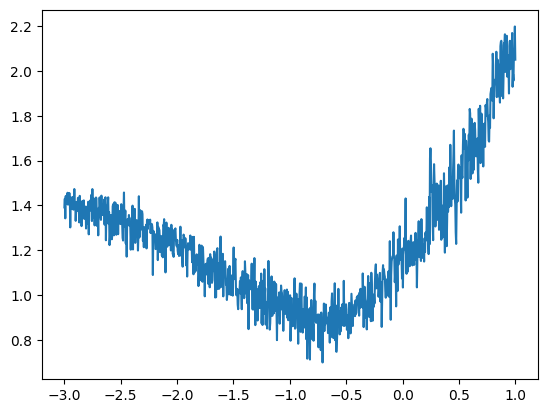

In [41]:
plt.plot(torch.linspace(-3, 1, 1000), lossi)


Looks like somewhere between -1.0 and -0.5 lets double down on this

In [42]:
params2 = create_model(emb_dim=10, hidden_size=200, window_size=3, vocab_size=len(stoi))
def lr_scheduler2(i):
    lre = torch.linspace(-1, 0.5, 1000)[i].item()
    lr = 10**lre
    return lr

In [ ]:
stepi, lossi = train(params2, X_train, y_train, epochs=1000,\
                      batch_size=32, lr_scheduler=lr_scheduler2)

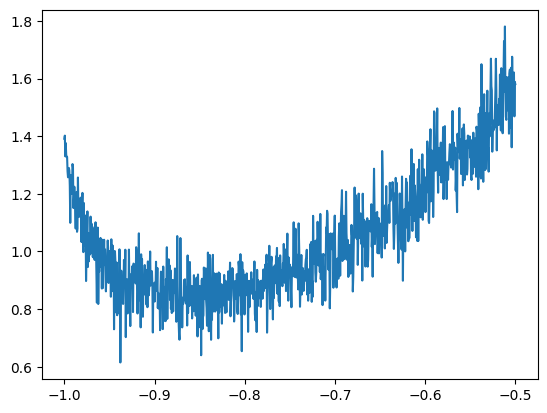

In [44]:
plt.plot(torch.linspace(-1, -0.5, 1000), lossi)


In [45]:
10 ** (-0.95)

0.11220184543019636

Best lr is `10**(-0.95) = 0.1122`

## Hypereparm optimization 

### Epochs: 100,000

In [47]:
params3 = create_model(emb_dim=10, hidden_size=200, window_size=3, vocab_size=len(stoi))
stepi, lossi = train(params3, X_train, y_train, epochs=100000,\
                      batch_size=32, lr_scheduler=lambda i: (10**(-0.95)))

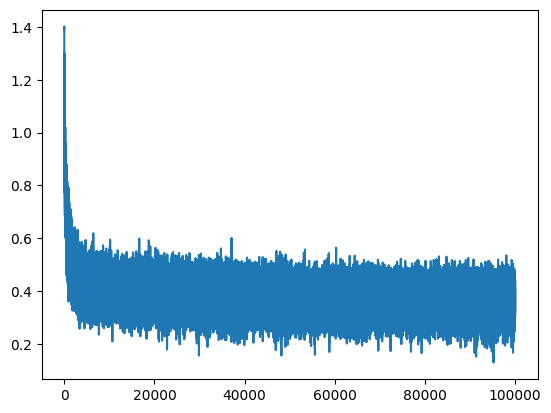

In [48]:
plt.plot(stepi, lossi)


In [49]:
train_loss = get_loss(params3, X_train, y_train)
train_loss

2.3054275512695312

In [50]:
dev_loss = get_loss(params3, X_dev, y_dev)
dev_loss

2.3480656147003174

### Epochs: 200,000

In [51]:
params4 = create_model(emb_dim=10, hidden_size=200, window_size=3, vocab_size=len(stoi))
stepi, lossi = train(params4, X_train, y_train, epochs=200000,\
                      batch_size=32, lr_scheduler=lambda i: (10**(-0.95)))

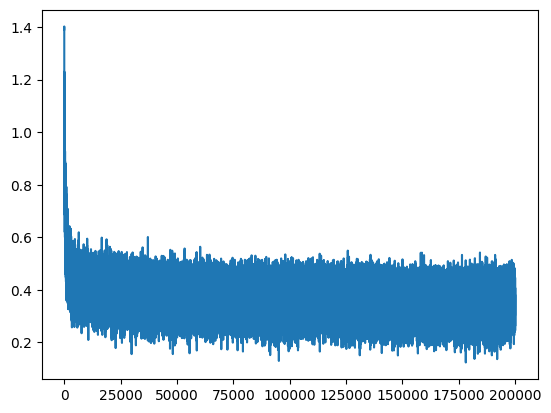

In [52]:
plt.plot(stepi, lossi)

In [53]:
train_loss = get_loss(params4, X_train, y_train)
dev_loss = get_loss(params4, X_dev, y_dev)
train_loss, dev_loss

(2.2369656562805176, 2.3001227378845215)

### Have a variant lr:

**Variant 1**: Slash lr by 10 every 100,000 steps

In [54]:
params5 = create_model(emb_dim=10, hidden_size=200, window_size=3, vocab_size=len(stoi))
stepi, lossi = train(params5, X_train, y_train, epochs=200000,\
                      batch_size=32,\
                          lr_scheduler=lambda i: (10**(-0.95)) if i < 100000 else (10**(-1.95)))

In [55]:
train_loss = get_loss(params5, X_train, y_train)
dev_loss = get_loss(params5, X_dev, y_dev)
train_loss, dev_loss

(2.1220571994781494, 2.1686935424804688)

**Variant 2**: Have a beta decay

In [ ]:
params6 = create_model(emb_dim=10, hidden_size=200, window_size=3, vocab_size=len(stoi))
stepi, lossi = train(params6, X_train, y_train, epochs=200000,\
                      batch_size=32,\
                          lr_scheduler=lambda i: (0.1 * ((0.99999)**(i))))

In [62]:
train_loss = get_loss(params6, X_train, y_train)
dev_loss = get_loss(params6, X_dev, y_dev)
train_loss, dev_loss

(2.1385293006896973, 2.1743385791778564)

Add more epochs to this

In [63]:
params7 = create_model(emb_dim=10, hidden_size=200, window_size=3, vocab_size=len(stoi))
stepi, lossi = train(params7, X_train, y_train, epochs=300000,\
                      batch_size=32,\
                          lr_scheduler=lambda i: (0.1 * ((0.99999)**(i))))

In [64]:
train_loss = get_loss(params7, X_train, y_train)
dev_loss = get_loss(params7, X_dev, y_dev)
train_loss, dev_loss

(2.1228463649749756, 2.160787582397461)

Can `beta` be increased more ?

In [68]:
params8 = create_model(emb_dim=10, hidden_size=200, window_size=3, vocab_size=len(stoi))
stepi, lossi = train(params8, X_train, y_train, epochs=300000,\
                      batch_size=32,\
                          lr_scheduler=lambda i: (0.1 * ((0.999999)**(i))))

In [69]:
train_loss = get_loss(params8, X_train, y_train)
dev_loss = get_loss(params8, X_dev, y_dev)
train_loss, dev_loss

(2.15653920173645, 2.221261501312256)

### Iterate on batch size

We will iterate on batch size with the best epoch and lr scheduler and find out the best one

#### Batch size = 32

In [70]:
params_bs32 = create_model(emb_dim=10, hidden_size=200, window_size=3, vocab_size=len(stoi))
stepi, lossi = train(params_bs32, X_train, y_train, epochs=200000,\
                      batch_size=32,\
                          lr_scheduler=lambda i: (10**(-0.95)) if i < 100000 else (10**(-1.95)))

In [71]:
train_loss = get_loss(params_bs32, X_train, y_train)
dev_loss = get_loss(params_bs32, X_dev, y_dev)
train_loss, dev_loss

(2.1220571994781494, 2.1686935424804688)

#### Batch size = 128

In [73]:
params_bs128 = create_model(emb_dim=10, hidden_size=200, window_size=3, vocab_size=len(stoi))
stepi, lossi = train(params_bs128, X_train, y_train, epochs=200000,\
                      batch_size=128,\
                          lr_scheduler=lambda i: (10**(-0.95)) if i < 100000 else (10**(-1.95)))

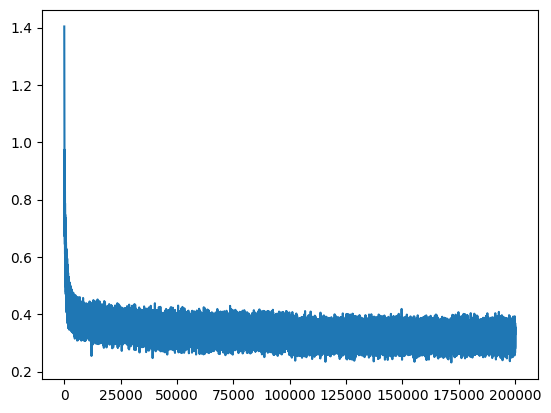

In [75]:
plt.plot(stepi, lossi)

In [74]:
train_loss = get_loss(params_bs128, X_train, y_train)
dev_loss = get_loss(params_bs128, X_dev, y_dev)
train_loss, dev_loss

(2.1108133792877197, 2.14689040184021)

#### Batch size = 512

In [76]:
params_bs512 = create_model(emb_dim=10, hidden_size=200, window_size=3, vocab_size=len(stoi))
stepi, lossi = train(params_bs512, X_train, y_train, epochs=200000,\
                      batch_size=512,\
                          lr_scheduler=lambda i: (10**(-0.95)) if i < 100000 else (10**(-1.95)))

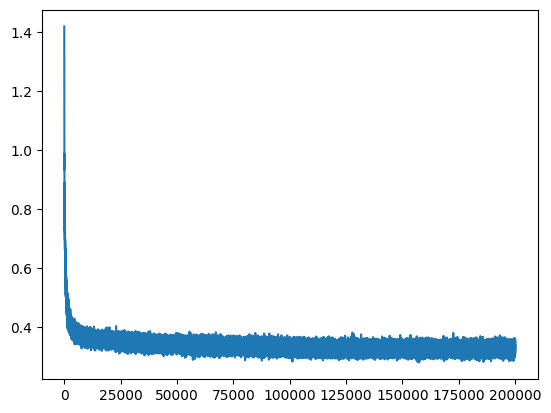

In [77]:
plt.plot(stepi, lossi)

In [78]:
train_loss = get_loss(params_bs512, X_train, y_train)
dev_loss = get_loss(params_bs512, X_dev, y_dev)
train_loss, dev_loss

(2.116922378540039, 2.1530978679656982)

#### Batch size = 256

In [79]:
params_bs256 = create_model(emb_dim=10, hidden_size=200, window_size=3, vocab_size=len(stoi))
stepi, lossi = train(params_bs256, X_train, y_train, epochs=200000,\
                      batch_size=256,\
                          lr_scheduler=lambda i: (10**(-0.95)) if i < 100000 else (10**(-1.95)))

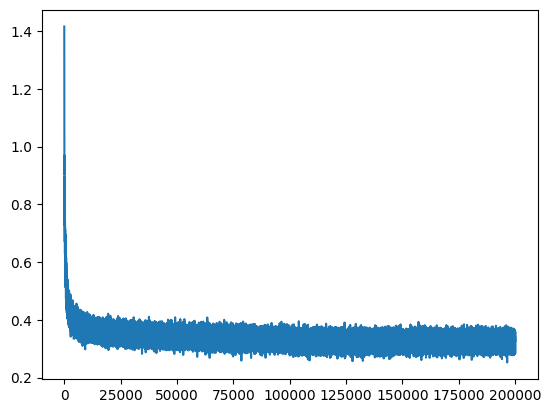

In [80]:
plt.plot(stepi, lossi)

In [83]:
train_loss = get_loss(params_bs256, X_train, y_train)
dev_loss = get_loss(params_bs256, X_dev, y_dev)
train_loss, dev_loss

(2.1137709617614746, 2.1551270484924316)

### Iterate on emb dim

#### Emb dim = 10

In [84]:
params_embdim10 = create_model(emb_dim=10, hidden_size=200, window_size=3, vocab_size=len(stoi))
stepi, lossi = train(params_embdim10, X_train, y_train, epochs=200000,\
                      batch_size=128,\
                          lr_scheduler=lambda i: (10**(-0.95)) if i < 100000 else (10**(-1.95)))

In [85]:
train_loss = get_loss(params_embdim10, X_train, y_train)
dev_loss = get_loss(params_embdim10, X_dev, y_dev)
train_loss, dev_loss

(2.1108133792877197, 2.14689040184021)

#### Emb dim = 20

In [94]:
params_embdim20 = create_model(emb_dim=20, hidden_size=200, window_size=3, vocab_size=len(stoi))
stepi, lossi = train(params_embdim20, X_train, y_train, epochs=200000,\
                      batch_size=128,\
                          lr_scheduler=lambda i: (10**(-0.95)) if i < 100000 else (10**(-1.95)))

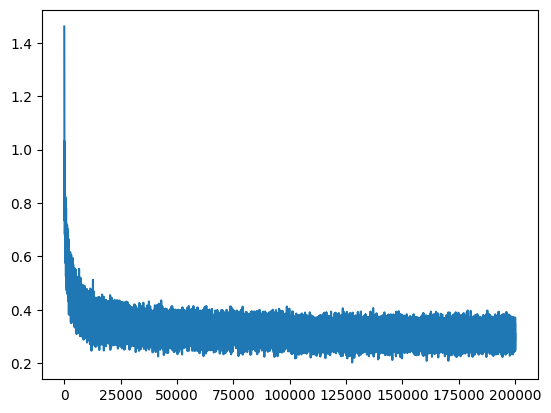

In [96]:
plt.plot(stepi, lossi)

In [95]:
train_loss = get_loss(params_embdim20, X_train, y_train)
dev_loss = get_loss(params_embdim20, X_dev, y_dev)
train_loss, dev_loss

(2.0392491817474365, 2.1392910480499268)

#### Emb dim = 30

In [97]:
params_embdim30 = create_model(emb_dim=30, hidden_size=200, window_size=3, vocab_size=len(stoi))
stepi, lossi = train(params_embdim30, X_train, y_train, epochs=200000,\
                      batch_size=128,\
                          lr_scheduler=lambda i: (10**(-0.95)) if i < 100000 else (10**(-1.95)))

In [98]:
train_loss = get_loss(params_embdim30, X_train, y_train)
dev_loss = get_loss(params_embdim30, X_dev, y_dev)
train_loss, dev_loss

(2.0345401763916016, 2.1321792602539062)

### Iterate on hidden size dimension

#### Hidden dim = 100

In [99]:
params_hidden100 = create_model(emb_dim=10, hidden_size=100, window_size=3, vocab_size=len(stoi))
stepi, lossi = train(params_hidden100, X_train, y_train, epochs=200000,\
                      batch_size=128,\
                          lr_scheduler=lambda i: (10**(-0.95)) if i < 100000 else (10**(-1.95)))

In [100]:
train_loss = get_loss(params_hidden100, X_train, y_train)
dev_loss = get_loss(params_hidden100, X_dev, y_dev)
train_loss, dev_loss

(2.1332943439483643, 2.15757417678833)

#### Hidden dim = 200

In [101]:
params_hidden200 = create_model(emb_dim=10, hidden_size=200, window_size=3, vocab_size=len(stoi))
stepi, lossi = train(params_hidden200, X_train, y_train, epochs=200000,\
                      batch_size=128,\
                          lr_scheduler=lambda i: (10**(-0.95)) if i < 100000 else (10**(-1.95)))

In [102]:
train_loss = get_loss(params_hidden200, X_train, y_train)
dev_loss = get_loss(params_hidden200, X_dev, y_dev)
train_loss, dev_loss

(2.1108133792877197, 2.14689040184021)

#### Hidden dim = 400

In [103]:
params_hidden400 = create_model(emb_dim=10, hidden_size=400, window_size=3, vocab_size=len(stoi))
stepi, lossi = train(params_hidden400, X_train, y_train, epochs=200000,\
                      batch_size=128,\
                          lr_scheduler=lambda i: (10**(-0.95)) if i < 100000 else (10**(-1.95)))

In [104]:
train_loss = get_loss(params_hidden400, X_train, y_train)
dev_loss = get_loss(params_hidden400, X_dev, y_dev)
train_loss, dev_loss

(2.080937623977661, 2.1333234310150146)

#### Hidden dim = 800

In [105]:
params_hidden800 = create_model(emb_dim=10, hidden_size=800, window_size=3, vocab_size=len(stoi))
stepi, lossi = train(params_hidden800, X_train, y_train, epochs=200000,\
                      batch_size=128,\
                          lr_scheduler=lambda i: (10**(-0.95)) if i < 100000 else (10**(-1.95)))

In [106]:
train_loss = get_loss(params_hidden800, X_train, y_train)
dev_loss = get_loss(params_hidden800, X_dev, y_dev)
train_loss, dev_loss

(2.0578806400299072, 2.1743080615997314)

#### Hidden dim = 600

In [107]:
params_hidden600 = create_model(emb_dim=10, hidden_size=600, window_size=3, vocab_size=len(stoi))
stepi, lossi = train(params_hidden600, X_train, y_train, epochs=200000,\
                      batch_size=128,\
                          lr_scheduler=lambda i: (10**(-0.95)) if i < 100000 else (10**(-1.95)))

In [ ]:
train_loss = get_loss(params_hidden600, X_train, y_train)
dev_loss = get_loss(params_hidden600, X_dev, y_dev)
train_loss, dev_loss

(2.0583255290985107, 2.1537787914276123)

#### Hidden dim = 300

In [109]:
params_hidden300 = create_model(emb_dim=10, hidden_size=300, window_size=3, vocab_size=len(stoi))
stepi, lossi = train(params_hidden300, X_train, y_train, epochs=200000,\
                      batch_size=128,\
                          lr_scheduler=lambda i: (10**(-0.95)) if i < 100000 else (10**(-1.95)))

In [110]:
train_loss = get_loss(params_hidden300, X_train, y_train)
dev_loss = get_loss(params_hidden300, X_dev, y_dev)
train_loss, dev_loss

(2.093501567840576, 2.1440253257751465)

### Iterate on whether direct conections help!

In [112]:
params_direct_true = create_model(emb_dim=10, hidden_size=400, window_size=3,\
                                 vocab_size=len(stoi), direct=True)
stepi, lossi = train(params_direct_true, X_train, y_train, epochs=200000,\
                      batch_size=128,\
                          lr_scheduler=lambda i: (10**(-0.95)) if i < 100000 else (10**(-1.95)),\
                            direct=True)

In [113]:
train_loss = get_loss(params_direct_true, X_train, y_train, direct=True)
dev_loss = get_loss(params_direct_true, X_dev, y_dev, direct=True)
train_loss, dev_loss

(2.0785534381866455, 2.131584644317627)

## Get the test loss on the best model!

In [114]:
test_loss = get_loss(params_direct_true, X_test, y_test, direct=True)
test_loss

2.1577773094177246

## Sample from this model

In [130]:
g = torch.Generator().manual_seed(2147483647 + 10)

for i in range(20):
    curr_window, curr_name = ['.'] * 3, ""

    while True:
        ix = [stoi[ch] for ch in curr_window]
        ix = torch.Tensor(ix).long().view(1,-1)

        logit = forward(ix, params_direct_true, direct=True)
        probs = torch.softmax(logit, dim=1).view(-1)

        curr_idx = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        curr_char = itos[curr_idx]

        if curr_char == '.':
            break

        curr_name += curr_char
        curr_window.append(curr_char)
        curr_window = curr_window[1:]

    print(curr_name)

carmah
amelle
khy
miliath
cassanden
jazonen
den
rha
kaeli
ner
kiah
maiir
kaleigh
ham
jore
quinn
suline
liveni
watthoniearynix
kael


# Now iterate on window size

## Window size = 4

In [135]:
X_train, y_train = create_dataset(names_train, window_size=4)
X_dev, y_dev = create_dataset(names_dev, window_size=4)
X_test, y_test = create_dataset(names_test, window_size=4)
X_train.shape, y_train.shape, X_dev.shape, y_dev.shape, X_test.shape, y_test.shape

(torch.Size([182497, 4]),
 torch.Size([182497]),
 torch.Size([22882, 4]),
 torch.Size([22882]),
 torch.Size([22767, 4]),
 torch.Size([22767]))

In [136]:
params_direct_true_ws4 = create_model(emb_dim=10, hidden_size=400, window_size=4,\
                                 vocab_size=len(stoi), direct=True)
stepi, lossi = train(params_direct_true_ws4, X_train, y_train, epochs=300000,\
                      batch_size=128,\
                          lr_scheduler=lambda i: (10**(-0.95)) if i < 100000 else (10**(-1.95)),\
                            direct=True)

In [137]:
train_loss = get_loss(params_direct_true_ws4, X_train, y_train, direct=True)
dev_loss = get_loss(params_direct_true_ws4, X_dev, y_dev, direct=True)
train_loss, dev_loss

(2.0724871158599854, 2.165146589279175)

In [138]:
test_loss = get_loss(params_direct_true_ws4, X_test, y_test, direct=True)
test_loss

2.176605224609375

In [ ]:
for p in params_direct_true_ws4:
    print(p.shape)

torch.Size([27, 10])
torch.Size([40, 400])
torch.Size([400])
torch.Size([400, 27])
torch.Size([27])
torch.Size([40, 27])


## Window size = 5

In [140]:
X_train, y_train = create_dataset(names_train, window_size=5)
X_dev, y_dev = create_dataset(names_dev, window_size=5)
X_test, y_test = create_dataset(names_test, window_size=5)
X_train.shape, y_train.shape, X_dev.shape, y_dev.shape, X_test.shape, y_test.shape

(torch.Size([182497, 5]),
 torch.Size([182497]),
 torch.Size([22882, 5]),
 torch.Size([22882]),
 torch.Size([22767, 5]),
 torch.Size([22767]))

In [149]:
for p in params_direct_true_ws5:
    print(p.shape)

torch.Size([27, 10])
torch.Size([50, 800])
torch.Size([800])
torch.Size([800, 27])
torch.Size([27])
torch.Size([50, 27])


In [153]:
params_direct_true_ws5 = create_model(emb_dim=20, hidden_size=400, window_size=5,\
                                 vocab_size=len(stoi), direct=True)
stepi, lossi = train(params_direct_true_ws5, X_train, y_train, epochs=300000,\
                      batch_size=128,\
                          lr_scheduler=lambda i: (10**(-0.95)) if i < 100000 else (10**(-1.95)),\
                            direct=True)

In [154]:
train_loss = get_loss(params_direct_true_ws5, X_train, y_train, direct=True)
dev_loss = get_loss(params_direct_true_ws5, X_dev, y_dev, direct=True)
train_loss, dev_loss

(2.0470385551452637, 2.104328155517578)

In [155]:
test_loss = get_loss(params_direct_true_ws5, X_test, y_test, direct=True)
test_loss

2.128878355026245

## Sample from this

In [160]:
g = torch.Generator().manual_seed(2147483647 + 3)

for i in range(20):
    curr_window, curr_name = ['.'] * 5, ""

    while True:
        ix = [stoi[ch] for ch in curr_window]
        ix = torch.Tensor(ix).long().view(1,-1)

        logit = forward(ix, params_direct_true_ws5, direct=True)
        probs = torch.softmax(logit, dim=1).view(-1)

        curr_idx = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        curr_char = itos[curr_idx]

        if curr_char == '.':
            break

        curr_name += curr_char
        curr_window.append(curr_char)
        curr_window = curr_window[1:]

    print(curr_name)

vicksy
wynnie
fonter
shamani
chaiso
micka
orson
falah
erry
addie
cosud
keelandr
eevan
davon
dyanna
stophor
nasiyo
aminah
catana
elion
